# Rotational dynamics Quickstart

*Authors: Andrey Yachmenev & Cem Saribal*

Calculation of rotational dynamics proceeds in two steps. At the first step, we obtain molecular field-free rotational energies, wave functions, and matrix elements of desired electric and magnetic property tensors, such as, for example, dipole moment or polarizability. At the second step, we solve the time-dependent problem with applied external electric and magnetic fields using the field-free solutions obtained at the first step as basis.

## Molecular field-free rotational solutions

In [96]:
from richmol.rot import Molecule, solve, LabTensor

Here is an example for water molecule, using data obtained from a quantum chemical calculation

In [97]:
water = Molecule()

# Cartesian coordinates of atoms
water.XYZ = ("bohr",
             "O",  0.00000000,   0.00000000,   0.12395915,
             "H",  0.00000000,  -1.43102686,  -0.98366080,
             "H",  0.00000000,   1.43102686,  -0.98366080)

# choose frame of principal axes of inertia
water.frame = "ipas"

# molecular frame dipole moment (au)
water.dip = [0, 0, -0.7288]

# molecular frame polarizability tensor (au)
water.pol = [[9.1369, 0, 0], [0, 9.8701, 0], [0, 0, 9.4486]]

# symmetry group
water.sym = "D2"

# rotational solutions for J=0..5
Jmax = 5
sol = solve(water, Jmin=0, Jmax=Jmax)

# laboratory-frame dipole moment operator
dip = LabTensor(water.dip, sol, thresh=1e-12) #neglect matrix elements smaller than `thresh`

# laboratory-frame polarizability tensor
pol = LabTensor(water.pol, sol, thresh=1e-12)

# field-free Hamiltonian
h0 = LabTensor(water, sol, thresh=1e-12)

The dictionary `sol[J][sym]` contains solutions for different values of $J$ (int) and different symetries (str). The state energies and state assignments (by $J, k, \tau$ quantum numbers) can be printed out as following

In [98]:
print("J  sym #    energy      J   k  tau  |leading coef|^2")
for J in sol.keys():
    for sym in sol[J].keys():
        for i in range(sol[J][sym].nstates):
            print(J, "%4s"%sym, i, "%12.6f"%sol[J][sym].enr[i], sol[J][sym].assign[i])

J  sym #    energy      J   k  tau  |leading coef|^2
0    A 0     0.000000 ['0' '0' '0' ' 1.000000']
1   B1 0    41.996372 ['1' '0' '1' ' 1.000000']
1   B2 0    36.931654 ['1' '1' '0' ' 1.000000']
1   B3 0    24.103743 ['1' '1' '1' ' 1.000000']
2    A 0    71.083285 ['2' '2' '0' ' 0.859287']
2    A 1   134.980252 ['2' '0' '0' ' 0.859287']
2   B1 0    80.074422 ['2' '2' '1' ' 1.000000']
2   B2 0    95.268576 ['2' '1' '0' ' 1.000000']
2   B3 0   133.752307 ['2' '1' '1' ' 1.000000']
3    A 0   206.063537 ['3' '2' '0' ' 1.000000']
3   B1 0   174.290919 ['3' '2' '1' ' 0.709733']
3   B1 1   283.750848 ['3' '0' '1' ' 0.709733']
3   B2 0   144.095391 ['3' '3' '0' ' 0.967197']
3   B2 1   283.558067 ['3' '1' '0' ' 0.967197']
3   B3 0   138.894101 ['3' '3' '1' ' 0.865893']
3   B3 1   211.791894 ['3' '1' '1' ' 0.865893']
4    A 0   225.839342 ['4' '4' '0' ' 0.897851']
4    A 1   316.682576 ['4' '2' '0' ' 0.534048']
4    A 2   487.795766 ['4' '0' '0' ' 0.612490']
4   B1 0   228.396486 ['4' '4' '1' 

The matrix elements of dipole moment and polarizability can be pronted as 2D matrices, in dese or sparse formats, using `tomat` method

In [99]:
# X-component of dipole moment
mu_x = dip.tomat(form="full", cart="x")

# XZ-component of polarizability
alpha_xz = pol.tomat(form="full", cart="xz")

# field-free Hamiltonian (diagonal)
h0mat = h0.tomat(form="full", cart="0")

print("matrix dimensions:", h0mat.shape)
print("dipole X:", mu_x)
print("\npolarizability XZ:", alpha_xz)
print("\nfield-free Hamiltonian:", h0mat)

matrix dimensions: (286, 286)
dipole X:   (0, 4)	(-9.739787996057844e-35-0.2975313540900633j)
  (0, 6)	(9.739787996057844e-35+0.2975313540900633j)
  (1, 8)	(-8.434903832060798e-35-0.25766971106437786j)
  (1, 30)	(1.3610889671164236e-34+0.2822630262715965j)
  (1, 32)	(-5.55662243994505e-35-0.11523339793653574j)
  (2, 7)	(-8.434903832060798e-35-0.25766971106437786j)
  (2, 9)	(-8.434903832060798e-35-0.25766971106437786j)
  (2, 31)	(9.624352384462173e-35+0.19959009995488255j)
  (2, 33)	(-9.624352384462173e-35-0.19959009995488255j)
  (3, 8)	(-8.434903832060798e-35-0.25766971106437786j)
  (3, 32)	(5.55662243994505e-35+0.11523339793653574j)
  (3, 34)	(-1.3610889671164236e-34-0.2822630262715965j)
  (4, 0)	(-9.739787996057844e-35+0.2975313540900633j)
  (4, 10)	(3.774036515276408e-33+0.20052055607190467j)
  (4, 11)	(1.887018257638204e-33+0.25694628736880804j)
  (4, 14)	(-1.5407439555097885e-33-0.08186217421921828j)
  (4, 15)	(-7.7037197775489426e-34-0.10489788255935238j)
  (5, 12)	(2.66864681239

The matrix elements above correspond to a full rotational basis spanned by $J=0..J_{max}$, $m=-J..J$, and $k=-J..J$. The assignment of each of these states by symmetric-top functions can be obtained using `assign` method

In [100]:
assign_bra, assign_ket = h0.assign(form="full") # `assign_bra` and `assign_ket` are equivalent in this case

# print assignment of first 20 states
for i in range(20):
    print(i, "J =", assign_bra["J"][i], 
          ", sym =", assign_bra["sym"][i], 
          ", m =", assign_bra["m"][i], 
          ", k =", assign_bra["k"][i])

0 J = 0.0 , sym = A , m = 0 , k = ('0 0  1.000000', 0.0)
1 J = 1.0 , sym = B1 , m = -1 , k = ('0 1  1.000000', 41.996371682354464)
2 J = 1.0 , sym = B1 , m = 0 , k = ('0 1  1.000000', 41.996371682354464)
3 J = 1.0 , sym = B1 , m = 1 , k = ('0 1  1.000000', 41.996371682354464)
4 J = 1.0 , sym = B2 , m = -1 , k = ('1 0  1.000000', 36.93165361155496)
5 J = 1.0 , sym = B2 , m = 0 , k = ('1 0  1.000000', 36.93165361155496)
6 J = 1.0 , sym = B2 , m = 1 , k = ('1 0  1.000000', 36.93165361155496)
7 J = 1.0 , sym = B3 , m = -1 , k = ('1 1  1.000000', 24.103743154821103)
8 J = 1.0 , sym = B3 , m = 0 , k = ('1 1  1.000000', 24.103743154821103)
9 J = 1.0 , sym = B3 , m = 1 , k = ('1 1  1.000000', 24.103743154821103)
10 J = 2.0 , sym = A , m = -2 , k = ('2 0  0.859287 2 0 0  0.140713', 71.08328455834958)
11 J = 2.0 , sym = A , m = -2 , k = ('0 0  0.859287 2 2 0  0.140713', 134.98025233911153)
12 J = 2.0 , sym = A , m = -1 , k = ('2 0  0.859287 2 0 0  0.140713', 71.08328455834958)
13 J = 2.0 , sym =

The 'k' group assignment above contains a tuple where the first element is the assignment of rotational state by $J, k, \tau$ quantum numbers (the same as printed out from `sol[J][sym].assign`) and the second element is the rotational state energy (same as `sol[J][sym].enr`).

## Static field simulations

Let's apply static electric field of varying strength along the laboratory $Z$ axis and compute the associated Stark shifts of rotational energies

In [130]:
import numpy as np
from richmol.convert_units import AUdip_x_Vm_to_invcm

enr = []
muz = []

muz0 = dip.tomat(form="full", cart="z") # matrix representation of Z-dipole at zero field

fz_grid = np.linspace(1, 1000*100, 10)

for fz in fz_grid: # field in V/m

    field = [0, 0, fz] # X, Y, Z field components in V/m

    # Hamiltonian
    h = h0 - dip * field * AUdip_x_Vm_to_invcm() # `AUdip_x_Vm_to_invcm` converts dipole(au) * field(V/m) into cm^-1

    # eigenproblem solution
    e, v = np.linalg.eigh(h.tomat(form='full', repres='dense'))

    # keep field-dressed energies
    enr.append([elem for elem in e])

    # keep field-dressed matrix elements of Z-dipole
    muz.append( np.dot(np.conjugate(v.T), muz0.dot(v)) )

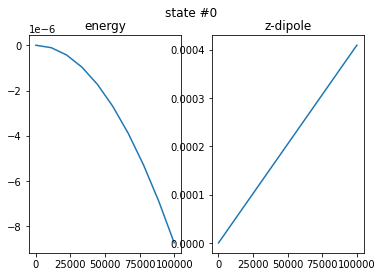

In [131]:
import matplotlib.pyplot as plt

# plot energies and dipoles vs field

enr = np.array(enr)
muz = np.array(muz)

istate = 0
fig, (ax1, ax2) = plt.subplots(1,2)
plt.suptitle(f"state #{istate}")
ax1.set_title("energy")
ax2.set_title("z-dipole")
ax1.plot(fz_grid, enr[:,istate])
ax2.plot(fz_grid, muz[:,istate, istate].real)

Owing to dipole selection rules, when the field is applied along the laboratory $Z$ axis, it holds that matrix elements for $m \neq m'$ are zero. This means that the Hamiltonian matrix is block diagonal, where different blocks correspond to different values of $m=m'$. In order to extract matrix representation of dipole for fixed value of $m$ and $m'$ quantum numbers one can use `filter` method (modifies tensor in place) or `filter` function (creates new object). The filter function accepts as arguments state quantum numbers $J$, $m$, and $k$, symmetry, and energy and returns `True` or `False` depending on if the corresponding state needs to be included or excluded form the basis. This is how we can do it to make the above Stark energy calculations more efficient by recognising the $m$-block structure of the Hamiltonian matrix

In [147]:
from richmol.field import filter

def flt(**kw):
    """Filter function to select states with m = _m"""
    if 'm' in kw:
        m = kw['m']
        return m == _m
    return True

# dicts to keep tensors for different m quanta
dip_m = {}
h0_m = {}

for _m in range(-Jmax, Jmax+1):
    dip_m[_m] = filter(dip, bra=flt, ket=flt)
    h0_m[_m] = filter(h0, bra=flt, ket=flt)
    print(f"matrix dimensions for m = {_m}:", dip_m[_m].tomat(form="full", cart="x").shape)
print("full matrix dimension:", dip.tomat(form="full", cart="x").shape)

matrix dimensions for m = -5: (11, 11)
matrix dimensions for m = -4: (20, 20)
matrix dimensions for m = -3: (27, 27)
matrix dimensions for m = -2: (32, 32)
matrix dimensions for m = -1: (35, 35)
matrix dimensions for m = 0: (36, 36)
matrix dimensions for m = 1: (35, 35)
matrix dimensions for m = 2: (32, 32)
matrix dimensions for m = 3: (27, 27)
matrix dimensions for m = 4: (20, 20)
matrix dimensions for m = 5: (11, 11)
full matrix dimension: (286, 286)


In [148]:
import numpy as np
from richmol.convert_units import AUdip_x_Vm_to_invcm

enr = {m : [] for m in h0_m.keys()}
muz = {m : [] for m in h0_m.keys()}

muz0 = {m : mat.tomat(form="full", cart="z") for m, mat in dip_m.items()} # matrix representation of Z-dipole at zero field

fz_grid = np.linspace(1, 1000*100, 10)

for m in h0_m.keys():

    for fz in fz_grid: # field in V/m

        field = [0, 0, fz] # X, Y, Z field components in V/m

        # Hamiltonian
        h = h0_m[m] - dip_m[m] * field * AUdip_x_Vm_to_invcm()

        # eigenproblem solution
        e, v = np.linalg.eigh(h.tomat(form='full', repres='dense'))

        # keep field-dressed energies
        enr[m].append([elem for elem in e])

        # keep field-dressed matrix elements of Z-dipole
        muz[m].append( np.dot(np.conjugate(v.T), muz0[m].dot(v)) )

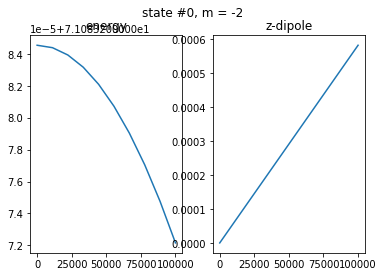

In [156]:
import matplotlib.pyplot as plt

# plot energies and dipoles vs field

enr = {m : np.array(val) for m, val in enr.items()}
muz = {m: np.array(val) for m, val in muz.items()}

istate = 0
m = -2
fig, (ax1, ax2) = plt.subplots(1,2)
plt.suptitle(f"state #{istate}, m = {m}")
ax1.set_title("energy")
ax2.set_title("z-dipole")
ax1.plot(fz_grid, enr[m][:,istate])
ax2.plot(fz_grid, muz[m][:,istate, istate].real)

In [ ]:
##############################################################################

Sometimes, matrix representation of tensor is needed in a subspace of the full basis. The representation of a tensor in a reduced basis can be generated using `filter` method (modifies tensor in place) or `filter` function (creates new object). In the following example, we generate field-free Hamiltonian, dipole moment, and polarizability tensors for different values of the $m$ quantum number, using `filter` function

## Time-dependent simulations

As an example, we simulate the mixed-field orientation of water molecule, produced by a static field combined with an elliptically-polarized laser field.

First, compute field-free energies and matrix elements of interaction tensor operators

In [51]:
from richmol.rot import Molecule, solve, LabTensor

water = Molecule()

water.XYZ = ("bohr",
             "O",  0.00000000,   0.00000000,   0.12395915,
             "H",  0.00000000,  -1.43102686,  -0.98366080,
             "H",  0.00000000,   1.43102686,  -0.98366080)

# molecular-frame dipole moment (au)
water.dip = [0, 0, -0.7288]

# molecular-frame polarizability tensor (au)
water.pol = [[9.1369, 0, 0], [0, 9.8701, 0], [0, 0, 9.4486]]

Jmax = 10
water.sym = "C2v"

sol = solve(water, Jmax=Jmax)

# laboratory-frame dipole moment operator
dip = LabTensor(water.dip, sol)

# laboratory-frame polarizability tensor
pol = LabTensor(water.pol, sol)

# field-free Hamiltonian
h0 = LabTensor(water, sol)

Molecule initially in static field. The initial wavepacket is a field-dressed state, which can be obtained as an eigenfunction of the corresponding molecule-field interaction Hamiltonian

In [52]:
from richmol.convert_units import AUdip_x_Vm_to_invcm
import numpy as np

# static field of 1 kV/cm along X axis
dc = [100000, 0, 0]

# dipole interaction Hamiltonian
H = h0 - dip * dc * AUdip_x_Vm_to_invcm()

# eigenvalues and eigenfunctions
enr, vec = np.linalg.eigh(H.tomat(form='full', repres='dense'))

In [82]:
# print assignments of first 10 lowest energy states

assign_bra, assign_ket = h0.assign(form='full') # assign_bra and assign_ket are equivalent here

# print two largest field-free contributions to each state

for i in range(10):
    v = np.abs(vec[:, i])
    ind = np.argmax(np.abs(v)) # index of the largest contributing field-free basis state
    v[ind] = 0
    ind2 = np.argmax(np.abs(v)) # index of the second largest contributing field-free basis state

    c = np.abs(vec[ind, i])**2
    J = assign_bra['J'][ind]
    m = assign_bra['m'][ind]
    k = assign_bra['k'][ind][0] # contains rotational (J,k,tau) (and vibrational) assignments of field-free states, skip printing it here
    e = assign_bra['k'][ind][1] # contains field-free energies
    shift = enr[i] - e

    c2 = np.abs(vec[ind2, i])**2
    J2 = assign_bra['J'][ind2]
    m2 = assign_bra['m'][ind2]
    k2 = assign_bra['k'][ind2][0] # contains rotational (J,k,tau) (and vibrational) assignments of field-free states, skip printing it here
    e2 = assign_bra['k'][ind2][1] # contains field-free energies
    shift2 = enr[i] - e2

    assign = ("%6.4f"%c, "%4.1f"%J, "%4.1f"%m, "%12.6g"%shift)
    if c2 > 0.4:
        assign += ("%6.4f"%c2, "%4.1f"%J2, "%4.1f"%m2, "%12.6g"%shift2)

    print(i, "%12.6f"%enr[i], assign)

0    -0.000009 ('1.0000', ' 0.0', ' 0.0', '-8.73306e-06')
1    24.103727 ('0.5618', ' 1.0', ' 0.0', '-1.61123e-05')
2    24.103727 ('0.4382', ' 1.0', ' 0.0', '-1.61123e-05')
3    24.103740 ('0.5000', ' 1.0', '-1.0', '-3.45745e-06', '0.5000', ' 1.0', ' 1.0', '-3.45745e-06')
4    36.931650 ('0.5000', ' 1.0', ' 1.0', '-3.37137e-06', '0.5000', ' 1.0', '-1.0', '-3.37137e-06')
5    36.931650 ('1.0000', ' 1.0', ' 0.0', '-3.37137e-06')
6    36.931658 ('0.5000', ' 1.0', '-1.0', ' 4.23789e-06', '0.5000', ' 1.0', ' 1.0', ' 4.23789e-06')
7    41.996370 ('0.5000', ' 1.0', ' 1.0', '-2.10903e-06', '0.5000', ' 1.0', '-1.0', '-2.10903e-06')
8    41.996384 ('0.3585', ' 1.0', ' 0.0', ' 1.19375e-05')
9    41.996384 ('0.6415', ' 1.0', ' 0.0', ' 1.19375e-05')


When printing assignments, please note that `assign(form='full')` returns dictionary with keys `'m'`, `'k'`, `'sym'`, `'J'` and corresponding elements for every field-free basis state in the same order as they are used to build the matrix representation of tensor in the 2D-matrix form using `tomat(form='full')`. When using `assign(form='block')`, the returned object is nested dictionary with keys `[J][sym]['m']` and `[J][sym]['k']`, the order of elements is the same as used to build the matrix representation of tensor in the block-matrix form using `tomat(form='block')`.

... continue when TDSE is ready